In [1]:
# Import libraries
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from scipy.stats import f_oneway, tukey_hsd
from wordcloud import WordCloud, STOPWORDS

# Download required packages for text preprocessing and sentiment analysis (for first use only)
# nltk.download(["punkt_tab", "stopwords", "vader_lexicon", "wordnet"])

In [2]:
# Specify display format for type float
pd.options.display.float_format = '{:.3f}'.format

In [3]:
# Load data file
df = pd.read_csv("data/bored_panda_posts.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              2016 non-null   object 
 1   voting             2016 non-null   int64  
 2   nr_comments        1896 non-null   float64
 3   page_link          2016 non-null   object 
 4   link               2016 non-null   object 
 5   nr_postings_total  2016 non-null   int64  
 6   nr_postings_shown  2016 non-null   int64  
 7   post_id            2016 non-null   int64  
 8   is_ad              2016 non-null   bool   
 9   category_1         2007 non-null   object 
 10  category_2         1358 non-null   object 
 11  nr_authors         2016 non-null   int64  
 12  author_1           2007 non-null   object 
 13  author_2           1492 non-null   object 
 14  author_3           161 non-null    object 
 15  author_4           1 non-null      object 
 16  author_1_role      2007 

In [4]:
df.head()

,title,voting,nr_comments,page_link,link,nr_postings_total,nr_postings_shown,post_id,is_ad,category_1,...,author_1,author_2,author_3,author_4,author_1_role,author_2_role,author_3_role,author_4_role,is_compilation,date_posted
0,"80 Posts So Unhinged, You May End Up Laughing ...",61,6.000,https://www.boredpanda.com/page/1/,https://www.boredpanda.com/surreal-weird-image...,80,80,8078562,False,Curiosities,...,Adelaide Ross,Ieva Pečiulytė,NaN,NaN,"Writer, BoredPanda staff","Author, BoredPanda staff",NaN,NaN,True,2025-01-27
1,"""It Was A Warning"": Woman Receives Disturbing ...",26,4.000,https://www.boredpanda.com/page/1/,https://www.boredpanda.com/stranger-approaches...,0,0,8090374,False,Lifestyle,...,Binitha Jacob,Donata Leskauskaite,NaN,NaN,"Writer, BoredPanda staff","Author, BoredPanda staff",NaN,NaN,False,2025-01-27
2,Woman Reveals She Understood Every Insult From...,31,29.000,https://www.boredpanda.com/page/1/,https://www.boredpanda.com/hiding-speak-husban...,0,0,8077890,False,Family,...,Nikita Manot,Shelly Fourer,NaN,NaN,"Writer, BoredPanda staff","Author, BoredPanda staff",NaN,NaN,False,2025-01-27
3,Ryan Reynolds’ “Horrifically Mean” Treatment O...,-10,6.000,https://www.boredpanda.com/page/1/,https://www.boredpanda.com/tj-miller-speaks-ou...,0,0,8089627,False,Celebrities,...,Marina Urman,Karina Babenok,NaN,NaN,"Writer, BoredPanda staff","Author, BoredPanda staff",NaN,NaN,False,2025-01-27
4,Zoe Saldaña’s Blackface Scandal Comes Back To ...,22,4.000,https://www.boredpanda.com/page/1/,https://www.boredpanda.com/zoe-saldana-blackfa...,0,0,8091431,False,Celebrities,...,Marina Urman,Lei RV,NaN,NaN,"Writer, BoredPanda staff","Author, BoredPanda staff",NaN,NaN,False,2025-01-27


## Data Cleaning

### Drop ads

Colum "is_ad" depicts whether a posting is an advertisement or not. Those typically receive very low ratings and do not allow comments. Hence they are of no interest to this analysis and will be dropped from the dataframe.

In [5]:
df["is_ad"].sum()
# 132 ads

132

In [6]:
df[df["is_ad"]].head()

,title,voting,nr_comments,page_link,link,nr_postings_total,nr_postings_shown,post_id,is_ad,category_1,...,author_1,author_2,author_3,author_4,author_1_role,author_2_role,author_3_role,author_4_role,is_compilation,date_posted
36,Home Office Heroes: 24 Products That’ll Help Y...,-58,NaN,https://www.boredpanda.com/page/10/,https://www.boredpanda.com/shopping/office/ele...,24,24,7963845,True,Office Essentials,...,Eligijus Sinkunas,NaN,NaN,NaN,"Author, BoredPanda staff",NaN,NaN,NaN,True,2025-01-21
37,24 Fixes For Your Most Embarrassing Yet Unavoi...,-8,NaN,https://www.boredpanda.com/page/10/,https://www.boredpanda.com/shopping/beauty-sho...,24,24,8033934,True,Beauty & Self Care,...,Eligijus Sinkunas,NaN,NaN,NaN,"Author, BoredPanda staff",NaN,NaN,NaN,True,2025-01-21
52,Transforming Rentals (And Keeping Landlords Ha...,-59,NaN,https://www.boredpanda.com/page/100/,https://www.boredpanda.com/shopping/home-shopp...,21,21,7667524,True,Home & Garden,...,Eligijus Sinkunas,NaN,NaN,NaN,"Author, BoredPanda staff",NaN,NaN,NaN,True,2024-11-12
53,"23 Products With Reviews So Good, They’ll Make...",-91,NaN,https://www.boredpanda.com/page/100/,https://www.boredpanda.com/shopping/deals/thin...,23,23,7652990,True,Shopping,...,Eligijus Sinkunas,NaN,NaN,NaN,"Author, BoredPanda staff",NaN,NaN,NaN,True,2024-11-12
54,21 White Elephant Gifts That Prove Laughter Is...,-83,NaN,https://www.boredpanda.com/page/100/,https://www.boredpanda.com/shopping/funny-shop...,21,21,7601955,True,Funny And Unique Finds,...,Mariia Tkachenko,NaN,NaN,NaN,"Author, BoredPanda staff",NaN,NaN,NaN,True,2024-11-12


In [7]:
df[df["is_ad"]].describe()
# -> voting mean substantially negative, only 12/132 have comments

,voting,nr_comments,nr_postings_total,nr_postings_shown,post_id,nr_authors
count,132.000,12.000,132.000,132.000,132.000,132.000
mean,-94.470,4.917,22.273,22.273,7644108.182,0.962
std,69.520,7.856,12.407,12.407,508754.401,0.313
min,-348.000,0.000,0.000,0.000,5981618.000,0.000
25%,-115.250,0.000,20.000,20.000,7703989.000,1.000
50%,-78.500,1.000,22.000,22.000,7834656.500,1.000
75%,-50.000,7.250,24.000,24.000,7878598.750,1.000
max,25.000,26.000,100.000,100.000,8063265.000,2.000


In [8]:
# Drop ads
print("# rows prior to dropping ads:", len(df))
df = df[df["is_ad"] == False]
print("# rows after to dropping ads:", len(df))

# rows prior to dropping ads: 2016
# rows after to dropping ads: 1884


### Missings

In [9]:
df.isna().sum()
# -> Ok! Category and Author show some missing for listings that only have 1 category/author mentioned.
# Date posted has been swiftly checked and confirmed that for these listings, no date was provided.

title                   0
voting                  0
nr_comments             0
page_link               0
link                    0
nr_postings_total       0
nr_postings_shown       0
post_id                 0
is_ad                   0
category_1              0
category_2            648
nr_authors              0
author_1                0
author_2              396
author_3             1723
author_4             1883
author_1_role           0
author_2_role         207
author_3_role        1728
author_4_role        1883
is_compilation          0
date_posted            23
dtype: int64

### Date

In [10]:
# Reformat column to datetime type
print(df['date_posted'].dtype)
df['date_posted_reformatted'] = pd.to_datetime(df["date_posted"], format="%Y-%m-%d")
print(df['date_posted_reformatted'].dtype)
df.filter(like="date").head()

object
datetime64[ns]


,date_posted,date_posted_reformatted
0,2025-01-27,2025-01-27
1,2025-01-27,2025-01-27
2,2025-01-27,2025-01-27
3,2025-01-27,2025-01-27
4,2025-01-27,2025-01-27


In [11]:
print("Unique dates: ", len(df["date_posted_reformatted"].unique()))
print("Earliest date:", df["date_posted_reformatted"].min())
print("Latest date:  ", df["date_posted_reformatted"].max())

Unique dates:  80
Earliest date: 2024-10-31 00:00:00
Latest date:   2025-01-27 00:00:00


### Text Preprocessing

In [12]:
# create preprocess_text function
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# apply the function df
df["title_preprocessed"] = df["title"].apply(preprocess_text)
df.filter(like="title").head()

,title,title_preprocessed
0,"80 Posts So Unhinged, You May End Up Laughing ...","80 post unhinged , may end laughing glancing s..."
1,"""It Was A Warning"": Woman Receives Disturbing ...",`` warning '' : woman receives disturbing note...
2,Woman Reveals She Understood Every Insult From...,woman reveals understood every insult german i...
3,Ryan Reynolds’ “Horrifically Mean” Treatment O...,ryan reynolds ’ “ horrifically mean ” treatmen...
4,Zoe Saldaña’s Blackface Scandal Comes Back To ...,zoe saldaña ’ blackface scandal come back bite...


## Sentiment Analysis

In [13]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# create get_sentiment function
def get_sentiment(text):
    scores = sid.polarity_scores(text)
    neg = scores["neg"]
    neu = scores["neu"]
    pos = scores["pos"]
    comp = scores["compound"]
    return neg, neu, pos, comp

# apply get_sentiment function
sentiment_columns = ["sentiment_neg", "sentiment_neu", "sentiment_pos", "sentiment_compound"]
df[sentiment_columns] = df["title_preprocessed"].apply(get_sentiment).to_list()

In [14]:
# Show results
df.filter(["title"] + sentiment_columns).head()

,title,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
0,"80 Posts So Unhinged, You May End Up Laughing ...",0.000,0.686,0.314,0.494
1,"""It Was A Warning"": Woman Receives Disturbing ...",0.449,0.551,0.000,-0.691
2,Woman Reveals She Understood Every Insult From...,0.520,0.480,0.000,-0.758
3,Ryan Reynolds’ “Horrifically Mean” Treatment O...,0.394,0.606,0.000,-0.637
4,Zoe Saldaña’s Blackface Scandal Comes Back To ...,0.225,0.775,0.000,-0.440


In [15]:
df.filter(["title"] + sentiment_columns).describe()

,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound
count,1884.000,1884.000,1884.000,1884.000
mean,0.170,0.653,0.177,0.006
std,0.179,0.197,0.179,0.477
min,0.000,0.155,0.000,-0.952
25%,0.000,0.505,0.000,-0.402
50%,0.158,0.640,0.176,0.000
75%,0.302,0.769,0.298,0.421
max,0.728,1.000,0.775,0.925


### Sentiment compound classification

In [16]:
# Create column with final sentiment
def sentiment_classification(value):
    if value > 0: return "positive"
    if value < 0: return "negative"
    return "neutral"

df["sentiment"] = df["sentiment_compound"].apply(sentiment_classification)
df["sentiment"].value_counts()

sentiment
positive    833
negative    769
neutral     282
Name: count, dtype: int64

## Categorical Data Preparation

In this section, additional dataframes will be created storing values for the columns associated with categories and authors. The data will be stored in long format to account for multiple categories/authors listed. Alongside the post_id and an index, Sentiment will remain the only variable in the long format dataframe.

### Categories

#### Melt DF

In [17]:
# Reset index and create colum "index" for id_var in melt command
df = df.reset_index(drop=True)
df["index"] = df.index

# Transform df into long format
df_cat_long = pd.melt(df, id_vars=["post_id", "index", "sentiment"], 
                      value_vars=["category_1", "category_2"],
                      var_name="cat",
                      value_name="Category")

# Drop created var_name column
df_cat_long = df_cat_long.drop(["cat"], axis=1)
# Sort by "index" (original df.index)
df_cat_long = df_cat_long.sort_values(by="index")
# Drop rows that are NaN in Category column due to only being assigned 1 category.
df_cat_long = df_cat_long[df_cat_long["Category"].isna() == False]

df_cat_long

,post_id,index,sentiment,Category
0,8078562,0,positive,Curiosities
1,8090374,1,negative,Lifestyle
1885,8090374,1,negative,News
2,8077890,2,negative,Family
1886,8077890,2,negative,Relationships
...,...,...,...,...
1880,7696020,1880,neutral,Celebrities
1881,7691746,1881,neutral,Art
3766,7646576,1882,neutral,Funny
1882,7646576,1882,neutral,Comics


In [18]:
# Show unique values / counts
df_cat_long["Category"].value_counts()
# 68 unique values

Category
Relationships    385
News             250
Family           242
Funny            179
Curiosities      160
                ... 
Decorating         1
Sleep              1
Gardening          1
Halloween          1
Organizing         1
Name: count, Length: 68, dtype: int64

#### Create Category "Other"

In [19]:
# Observe categories with low counts to group in "others"
category_counts = df_cat_long["Category"].value_counts().to_frame()
print("Nr. catogries appearing in more than...")
print("10 postings:", sum(category_counts["count"] >= 10))
print("20 postings:", sum(category_counts["count"] >= 20))
print("Nr. catogries to be grouped in 'Others' with less than...")
print("10 postings:", category_counts.loc[category_counts["count"] < 10, "count"].sum())
print("20 postings:", category_counts.loc[category_counts["count"] < 20, "count"].sum())

Nr. catogries appearing in more than...
10 postings: 41
20 postings: 30
Nr. catogries to be grouped in 'Others' with less than...
10 postings: 97
20 postings: 257


In [20]:
# Set threshold and extract names of those categories being grouped in "others" in next step.
others_names = category_counts[category_counts["count"] < 10].index.to_list()
others_names[:10]

['Work',
 'Tech&Science',
 'Community AITA',
 'Digital Art',
 'Needle and Thread',
 'Architecture',
 'Movies&TV',
 'Mental health',
 'Sports',
 'Beauty']

In [21]:
# Group categories with low count in "Other"
df_cat_long["Category Shortened"] = (df_cat_long["Category"]
                                     .apply(lambda x: "Other" if x in others_names else x))
df_cat_long["Category Shortened"].value_counts()

Category Shortened
Relationships      385
News               250
Family             242
Funny              179
Curiosities        160
Entertainment      155
Social Issues      152
Entitled People    134
Couples            112
Art                104
Celebrities        102
Other               97
Comics              93
Funny Memes         88
Work & Money        80
Animals             73
Fails               61
Wholesome           53
Parenting           44
Movies & tv         44
Photography         42
Friends             41
Dogs                36
Occasions           35
Crime               35
Health              33
US                  27
History             26
Community           26
Jokes               26
Cats                25
Home & Design       19
Christmas           17
Wedding             16
Lifestyle           16
Facts               16
Ask Pandas          15
World               15
Food                13
Tattoos             12
Travel              11
Feminism            10
Name: count, dt

In [22]:
# Create count column
df_cat_long["count"] = (df_cat_long["Category Shortened"]
                        .map(df_cat_long["Category Shortened"].value_counts()))

### Authors

#### Melt DF

In [23]:
# 1. Transform df into long format for authors' NAMES
author_cols = ['author_1', 'author_2', 'author_3', 'author_4']
df_author_long = pd.melt(df, id_vars=["post_id", "index", "sentiment", "nr_authors"], 
                         value_vars=author_cols,
                         var_name="author_id",
                         value_name="Author Name")

# 2. Transform df into long format for authors' ROLES
author_role_cols = ['author_1_role', 'author_2_role', 'author_3_role', 'author_4_role']
df_author_role_long = pd.melt(df, id_vars=["post_id", "index", "sentiment", "nr_authors"], 
                              value_vars=author_role_cols,
                              var_name="author_id",
                              value_name="Author Role")

# 3. "merge", i.e. add Author Role to sorted(!) df
df_author_long = df_author_long.sort_values(by=["post_id", "author_id"])
df_author_role_long = df_author_role_long.sort_values(by=["post_id", "author_id"])
df_author_long["Author Role"] = df_author_role_long["Author Role"]

# Sort by "index" (original df.index)
df_author_long = df_author_long.sort_values(by=["index", "author_id"])

# Drop rows that are NaN in both new author columns.
df_author_long = (df_author_long[(df_author_long["Author Name"].isna() == False) | 
                                 (df_author_long["Author Role"].isna() == False)])

# Strip white space from Author columns
df_author_long["Author Name"] = df_author_long["Author Name"].str.strip()
df_author_long["Author Role"] = df_author_long["Author Role"].str.strip()
df_author_long["Author Role"] = df_author_long["Author Role"].str.replace("  ", " ")

df_author_long

,post_id,index,sentiment,nr_authors,author_id,Author Name,Author Role
0,8078562,0,positive,2,author_1,Adelaide Ross,"Writer, BoredPanda staff"
1884,8078562,0,positive,2,author_2,Ieva Pečiulytė,"Author, BoredPanda staff"
1,8090374,1,negative,2,author_1,Binitha Jacob,"Writer, BoredPanda staff"
1885,8090374,1,negative,2,author_2,Donata Leskauskaite,"Author, BoredPanda staff"
2,8077890,2,negative,2,author_1,Nikita Manot,"Writer, BoredPanda staff"
...,...,...,...,...,...,...,...
3765,7691746,1881,neutral,1,author_2,NaN,"Moderator, BoredPanda staff"
1882,7646576,1882,neutral,1,author_1,Michael Samuels,"Author, Community member"
3766,7646576,1882,neutral,1,author_2,NaN,"Moderator, BoredPanda staff"
1883,7652004,1883,positive,1,author_1,Hidrėlėy,"Author, Pro member"


In [24]:
# Check reshaped dataframe's size for plausability
print(4*len(df) - df.filter(author_cols).isna().sum().sum())
print(4*len(df) - df.filter(author_role_cols).isna().sum().sum())

3534
3718


#### Missing Checks

In [25]:
# Check Author Roles for missing Author Names
df_author_long.loc[df_author_long["Author Name"].isna(), "Author Role"].value_counts()

Author Role
Moderator, BoredPanda staff    188
Author, Community member         1
Name: count, dtype: int64

In [26]:
# Most of them are "Moderators", perhaps mentioned without a name.
# 1 is an Author, this case should be checked again
check_id = (df_author_long.loc[(df_author_long["Author Name"].isna()) 
                               & (df_author_long["Author Role"] == "Author, Community member"),
                               "post_id"]).values[0]
df[df["post_id"] == check_id].filter(like="auth")

,nr_authors,author_1,author_2,author_3,author_4,author_1_role,author_2_role,author_3_role,author_4_role
1813,1,By Deleted User,NaN,NaN,NaN,"Moderator, BoredPanda staff","Author, Community member",NaN,NaN


In [27]:
df_author_long.loc[df_author_long["post_id"] == check_id]

,post_id,index,sentiment,nr_authors,author_id,Author Name,Author Role
1813,7701247,1813,positive,1,author_1,By Deleted User,"Moderator, BoredPanda staff"
3697,7701247,1813,positive,1,author_2,NaN,"Author, Community member"


In [28]:
# Looks like here, a moderator took over after the author deleted their profile.
# -> Swap this
df_author_long.loc[(df_author_long["post_id"] == check_id) & 
                   (df_author_long["author_id"] == "author_1"), "Author Role"] = "Author, Community member"

df_author_long.loc[(df_author_long["post_id"] == check_id) & 
                   (df_author_long["author_id"] == "author_2"), "Author Role"] = pd.NA

df_author_long.loc[df_author_long["post_id"] == check_id]

,post_id,index,sentiment,nr_authors,author_id,Author Name,Author Role
1813,7701247,1813,positive,1,author_1,By Deleted User,"Author, Community member"
3697,7701247,1813,positive,1,author_2,NaN,<NA>


In [29]:
# Check roles for missing names again
df_author_long.loc[df_author_long["Author Name"].isna(), "Author Role"].value_counts()

Author Role
Moderator, BoredPanda staff    188
Name: count, dtype: int64

In [30]:
# Drop rows where Author Name is NA
print(len(df_author_long))
df_author_long = df_author_long[df_author_long["Author Name"].isna() == False]
print(len(df_author_long))

3723
3534


In [31]:
# Check missings
df_author_long.isna().sum()

post_id        0
index          0
sentiment      0
nr_authors     0
author_id      0
Author Name    0
Author Role    5
dtype: int64

In [32]:
# 5 postings with missing author role
df_author_long[df_author_long["Author Role"].isna()]

,post_id,index,sentiment,nr_authors,author_id,Author Name,Author Role
4197,7948432,429,positive,3,author_3,Rude_Welcome_3269,NaN
4298,7948149,530,negative,3,author_3,Dismylik16thaccount,NaN
4410,7914256,642,positive,3,author_3,ENMR-OG,NaN
4478,7914315,710,neutral,3,author_3,Wizo_Muc,NaN
4597,7890529,829,negative,3,author_3,Infinite-Minute2004,NaN


In [33]:
# Unclear. Potentially "Member", but to be sure, remove those rows, too.
print(len(df_author_long))
df_author_long = df_author_long[df_author_long["Author Role"].isna() == False]
print(len(df_author_long))

3534
3529


#### Author Names

In [34]:
df_author_long["Author Name"].value_counts()
# 115 unique authors

Author Name
Hidrėlėy             146
Monika Pašukonytė    130
Rūta Zumbrickaitė    113
Justin Sandberg      105
Adelaide Ross        104
                    ... 
JunebugWeddings        1
Linas Jokubaitis       1
Creare                 1
Lisa D'Amico PhD       1
Michael Samuels        1
Name: count, Length: 115, dtype: int64

In [35]:
author_name_count = df_author_long["Author Name"].value_counts().to_frame()
print("Nr. authors with more than...")
print("10 postings:", sum(author_name_count["count"] >= 10))
print("20 postings:", sum(author_name_count["count"] >= 20))

Nr. authors with more than...
10 postings: 62
20 postings: 53


In [36]:
others_names = author_name_count[author_name_count["count"] < 10].index.to_list()
others_names[:5]

['Gabriela Zagórska',
 'Zo Aguila',
 'Ingrida Jasiukevičiūtė',
 'All About Photo',
 'Damanjeet Sethi']

In [37]:
df_author_long["Author Name Shortened"] = (df_author_long["Author Name"]
                                           .apply(lambda x: "Other" if x in others_names else x))
df_author_long["Author Name Shortened"].value_counts()

Author Name Shortened
Hidrėlėy                146
Monika Pašukonytė       130
Rūta Zumbrickaitė       113
Justin Sandberg         105
Adelaide Ross           104
                       ... 
Ieva Midveryte           13
Julija B.                13
Aurelija Rakauskaitė     12
Eglė Bliabaitė           11
Donata Ruzgaitė          10
Name: count, Length: 63, dtype: int64

In [38]:
# Create count column
df_author_long["author_count"] = (df_author_long["Author Name Shortened"]
                                  .map(df_author_long["Author Name Shortened"].value_counts()))

#### Author Role

In [39]:
df_author_long["Author Role"].value_counts()

Author Role
Author, BoredPanda staff       1808
Writer, BoredPanda staff       1455
Author, Pro member              146
Author, Community member         82
Moderator, BoredPanda staff      38
Name: count, dtype: int64

In [40]:
# Create count column
df_author_long["role_count"] = (df_author_long["Author Role"]
                                .map(df_author_long["Author Role"].value_counts()))

## Exploratory Data Analysis

### Post Stats

In [41]:
df["is_compilation_int"] = df["is_compilation"].astype(int)
stats = (df.groupby("sentiment")
         .agg({"sentiment": "count", 
               "voting": ["min", "mean", "std", "max"],
               "nr_comments": ["min", "mean", "std", "max"],
               "nr_postings_shown": ["min", "mean", "std", "max"],
               "nr_authors": ["min", "mean", "std", "max"],
               "is_compilation_int": ["min", "mean", "std", "max"],
               })
         .T)
stats.columns.name = "stat"
stats[["positive", "neutral", "negative"]]

stat                      positive  neutral  negative
sentiment          count   833.000  282.000   769.000
voting             min     -76.000 -184.000  -101.000
                   mean     49.952   35.507    39.756
                   std      35.325   41.213    27.077
                   max     213.000  186.000   241.000
nr_comments        min       0.000    0.000     0.000
                   mean     17.533   20.262    28.164
                   std      18.694   20.984    22.803
                   max     134.000  122.000   135.000
nr_postings_shown  min       0.000    0.000     0.000
                   mean     20.968   16.128    11.905
                   std      20.474   18.563    18.222
                   max     100.000   99.000    85.000
nr_authors         min       1.000    1.000     1.000
                   mean      1.808    1.727     2.004
                   std       0.608    0.578     0.373
                   max       4.000    3.000     3.000
is_compilation_int min       0.000    0.000     0.000
                   mean      0.570    0.507     0.328
                   std       0.495    0.501     0.470
                   max       1.000    1.000     1.000

### Top/Bottom Titles

In [42]:
# Increase max col width to show complete titles
pd.set_option('display.max_colwidth', None)

In [43]:
# Show entries with strongest negative sentiment.
df.sort_values(by="sentiment_compound").filter(["title", "sentiment_compound", "category_1"]).head(5)

,title,sentiment_compound,category_1
255,"""Dance On Her Grave"": Cruel Stepmother Nears Death, Woman Relishes Revenge For A Lifetime Of Pain",-0.952,Family
882,30 Examples Of ‘Urban Hell’ That Don’t Look Real But Sadly Are (Worst Of All Time),-0.910,Environment
1124,“So Heavy. So Fatty. This Is Death”: Guy Is Sick And Tired Of Wife’s Food Complaints,-0.906,Family
144,"Employee Makes Up An Evil Plan To Find Out And Punish Office Food Thief, Turns Out It Was Her Boss",-0.904,Work & Money
1480,“They Died?? I Thought They Fell Asleep!”: 50 Worst Cases Of People Misunderstanding The Plot,-0.903,Entertainment


In [44]:
# Show most positive entries.
df.sort_values(by="sentiment_compound", ascending=False).filter(["title", "sentiment_compound", "category_1"]).head(5)

,title,sentiment_compound,category_1
1021,45 Of The Funniest Cat Bleps Guaranteed To Bring Avid Cat Lovers Joy,0.925,Animals
1188,"40 Funny Tinder Chats That Might Not Have Ended In Love, But Definitely In Laughs (New Pics)",0.925,Funny
698,30 Beautiful Creations Inspired by Nature That People Were Excited to Share Online,0.915,DIY
912,Folks Share The Best Cat Smiles They’ve Ever Been Blessed To Witness (43 Photos),0.915,Animals
1107,50 Times Great Works Of Art Were The Perfect Canvas For The Funniest Memes (New Pics),0.908,Funny


In [45]:
# Show some entries with neutral sentiment value.
df.loc[df["sentiment_compound"]==0, ["title", "sentiment_compound", "category_1"]].head(5)

,title,sentiment_compound,category_1
6,Doctors Foreshadow Side Effects Of Ozempic As the Medication Takes Over Hollywood,0.000,Health
7,Would You Wear This? Internet Split Over This Dramatic Wedding Dress And Veil,0.000,Lifestyle
30,You May Learn Something New While Cackling At These 97 History-related Memes (New Pics),0.000,Funny
32,This UPS Driver’s 21 New Photos With Pets Are The Dose Of Wholesome Content You Need,0.000,Wholesome
33,30 Colorized Vintage Photos By Sebastien De Oliveira That Might Transform Your View Of History (New Pics),0.000,Art


In [46]:
# Show titles with most comments
df["nr_comments"] = df["nr_comments"].astype(int)
show_cols = ["title", "voting", "nr_comments", "category_1", "category_2", "is_compilation", "sentiment"]

df.filter(show_cols).sort_values(by="nr_comments", ascending=False).head(10)

,title,voting,nr_comments,category_1,category_2,is_compilation,sentiment
1126,"Vegetarian Mom Fears Family Will Feed Baby Meat Behind Her Back, Seeks Perspective Online",24,135,Parenting,NaN,False,negative
433,50 Screenshots Of Americans Being Peak Dumb That May Make You Feel Like A Genius (New Pics),38,134,Fails,Funny,True,negative
435,"Time’s Up: Serial Latecomer Pushes Friend To Snap, Leaves Lunch Date Without A Word",36,134,Friends,Relationships,False,positive
235,Meta Workers Left In “Shock And Disbelief” Amid Mark Zuckerberg’s Controversial LGBTQ+ Changes,18,130,Celebrities,News,False,negative
1845,Couple Get $3000 In Gifts From Their $60k Wedding: “We’re Freaking Out And Really Devastated”,-11,130,Occasions,Wedding,False,negative
580,"Dad Saves Son From Lifetime Of Bullying By Giving Him Regular Name, Sparks Grandma’s Rage",57,128,Family,Relationships,False,negative
699,"Netizens Point Out The 37 Biggest Movies They’ll Never Re-Watch Again, Under Any Circumstances",77,122,Entertainment,Movies & tv,True,neutral
54,Here Are 23 Canceled TV Shows And You Decide Whether They Deserve To Come Back,15,119,Entertainment,Movies & tv,True,neutral
1551,Diner Starts Debate After Waiter Rejects $25 Tip: “Tipping Culture Has Gotten Out Of Hand”,13,117,Entitled People,Social Issues,False,positive
1446,"“Super Cute, Right?” She Dressed Up For A Date, Then His First Comment Shattered Everything",17,113,News,Relationships,False,positive


In [47]:
# Show titles with highest voting
df.filter(show_cols).sort_values(by="voting", ascending=False).head(10)

,title,voting,nr_comments,category_1,category_2,is_compilation,sentiment
1616,50 Wholesome “Eye Bleach” Pics To Cleanse Your Eyes From The Horrors Of The Internet,241,42,Wholesome,NaN,True,negative
1625,50 Epic Comments That Were Better Than The Post (New Pics),213,47,Funny,Jokes,True,positive
1117,"If You Feel Like The World Is Going To Hell, These 50 Positive Stories May Change Your Mind",190,23,Wholesome,NaN,True,positive
50,50 Memes That Cat Owners Might Find Relatable,186,22,Funny,Funny Memes,True,neutral
130,50 Delightful Animal Memes To Help You Ignore What’s Happening In The World Right Now,173,19,Funny,Funny Memes,True,positive
1770,50 Hilarious Memes That Display British Humor At Its Finest,171,13,Funny,Funny Memes,True,positive
575,50 Cats That May Leave You Laughing So Hard You’ll Forget All Your Worries For A Minute (New Pics),170,21,Animals,Cats,True,negative
964,50 ‘Blessed Images’ That May Turn Your Day Around For The Better (New Pics),168,10,Wholesome,NaN,True,positive
1106,50 Wholesome Pics From The “Wholesome Meets The Internet” Account To Brighten Up Your Day (New Pics),160,11,Wholesome,NaN,True,positive
992,People Who’ve Mastered The Art Of Outwitting Felines Share Their Best Ever Cat Traps,155,25,Animals,Cats,True,positive


In [48]:
# Show titles with lowest voting
df.filter(show_cols).sort_values(by="voting", ascending=True).head(10)

,title,voting,nr_comments,category_1,category_2,is_compilation,sentiment
705,20 Stars Whose Dramatic Transformations Had Everyone Talking This Year,-184,28,Celebrities,News,True,neutral
1880,Who Is Sydney Sweeney’s Fiancé? A Glimpse Into Her Relationship With Jonathan Davino,-171,25,Celebrities,Entertainment,False,neutral
206,Kim Kardashian Kids: What We Know About Her Four Children,-127,14,Celebrities,Entertainment,False,neutral
1250,Who Is Kim Kardashian Dating? A Timeline Of Her Relationships,-123,10,Celebrities,Entertainment,False,neutral
1266,"AI Gives 18 Male Celebrities A Gender Swapped Look, Here’s The Result",-120,27,Celebrities,Entertainment,True,neutral
515,15 Celebrities Who Were Caught In Scandalous Affairs In 2024,-101,13,Celebrities,News,True,negative
550,30 Red Carpet Looks That Got It Wrong In 2024,-100,16,Celebrities,News,True,negative
548,Baby’s Appearance Prompted Mom To Seek DNA Test: “My Son Was Really Ugly”,-80,55,Family,News,False,negative
511,From Luigi Mangione To Keanu Reeves: 31 Viral Mugshots Of Criminal Heartthrobs,-79,30,Crime,News,True,negative
890,"After Dad Takes Own Life Looking For Her, Hannah Kobayashi Now Wants To Focus On Her Creativity",-76,17,News,US,False,positive


### Voting, Comments, and Avg compound per Category and Author

In [49]:
# Define helper function for printing top x entries
def print_top_bottom_n(df, column, n):
    print(f"Top {n} entries by column {column.upper()}:")
    print(df.sort_values(by=column, ascending=False).head(n))
    print(f"\nBottom {n} entries by column {column.upper()}:")
    print(df.sort_values(by=column, ascending=False).tail(n))

#### Categories

In [50]:
# Add compound, voting, and comments to long df
df_cat_long = df_cat_long.merge(df[["post_id", "sentiment_compound", "nr_comments", "voting"]], on="post_id")
df_cat_long.head()

,post_id,index,sentiment,Category,Category Shortened,count,sentiment_compound,nr_comments,voting
0,8078562,0,positive,Curiosities,Curiosities,160,0.494,6,61
1,8090374,1,negative,Lifestyle,Lifestyle,16,-0.691,4,26
2,8090374,1,negative,News,News,250,-0.691,4,26
3,8077890,2,negative,Family,Family,242,-0.758,29,31
4,8077890,2,negative,Relationships,Relationships,385,-0.758,29,31


In [51]:
# Create aggregated df
df_cat_long_agg = (df_cat_long
                   .groupby(["Category Shortened"])
                   .agg({"Category Shortened": "count",
                         "sentiment_compound": "mean",
                         "voting": "mean",
                         "nr_comments": "mean"})
                   .rename(columns={"Category Shortened": "count"}))
df_cat_long_agg.head()

,count,sentiment_compound,voting,nr_comments
Category Shortened,,,,
Animals,73,0.283,74.904,11.384
Art,104,0.297,49.615,7.413
Ask Pandas,15,0.213,15.200,2.867
Cats,25,0.273,88.760,12.880
Celebrities,102,-0.010,-10.127,12.990


In [52]:
# Print top and bottom entries
for col in ["sentiment_compound", "voting", "nr_comments"]:
    print_top_bottom_n(df_cat_long_agg, col, 5)
    print("\n")

Top 5 entries by column SENTIMENT_COMPOUND:
                    count  sentiment_compound  voting  nr_comments
Category Shortened                                                
Photography            42               0.426  58.429        6.619
Jokes                  26               0.418  90.962       23.000
Facts                  16               0.386  76.250       15.438
History                26               0.382  78.654       10.692
Comics                 93               0.357  38.860        3.333

Bottom 5 entries by column SENTIMENT_COMPOUND:
                    count  sentiment_compound  voting  nr_comments
Category Shortened                                                
Fails                  61              -0.210  71.623       18.426
Entitled People       134              -0.212  38.821       30.343
Social Issues         152              -0.213  38.447       31.217
Family                242              -0.247  38.955       36.740
Crime                  35            

#### Authors

In [53]:
# Add compound, voting, and comments to long df
df_author_long = df_author_long.merge(df[["post_id", "sentiment_compound", "nr_comments", "voting"]], on="post_id")
df_author_long.head()

,post_id,index,sentiment,nr_authors,author_id,Author Name,Author Role,Author Name Shortened,author_count,role_count,sentiment_compound,nr_comments,voting
0,8078562,0,positive,2,author_1,Adelaide Ross,"Writer, BoredPanda staff",Adelaide Ross,104,1455,0.494,6,61
1,8078562,0,positive,2,author_2,Ieva Pečiulytė,"Author, BoredPanda staff",Ieva Pečiulytė,70,1808,0.494,6,61
2,8090374,1,negative,2,author_1,Binitha Jacob,"Writer, BoredPanda staff",Binitha Jacob,45,1455,-0.691,4,26
3,8090374,1,negative,2,author_2,Donata Leskauskaite,"Author, BoredPanda staff",Donata Leskauskaite,49,1808,-0.691,4,26
4,8077890,2,negative,2,author_1,Nikita Manot,"Writer, BoredPanda staff",Nikita Manot,51,1455,-0.758,29,31


In [54]:
# Create aggregated df
df_author_long_agg = (df_author_long
                      .groupby(["Author Name Shortened"])
                      .agg({"Author Name Shortened": "count",
                            "sentiment_compound": "mean",
                            "nr_comments": "mean",
                            "voting": "mean"})
                      .rename(columns={"Author Name Shortened": "count"}))
df_author_long_agg.head()

,count,sentiment_compound,nr_comments,voting
Author Name Shortened,,,,
Abel Musa Miño,45,-0.001,16.889,19.867
Adelaide Ross,104,-0.011,28.038,52.125
Andréa Oldereide,65,-0.267,28.062,16.385
Aurelija Rakauskaitė,12,0.113,11.667,82.083
Austeja Zokaite,77,0.013,25.636,58.208


In [55]:
# Print top and bottom entries
for col in ["sentiment_compound", "voting", "nr_comments"]:
    print_top_bottom_n(df_author_long_agg, col, 5)
    print("\n")

Top 5 entries by column SENTIMENT_COMPOUND:
                       count  sentiment_compound  nr_comments  voting
Author Name Shortened                                                
Ieva Midveryte            13               0.444        3.692  41.615
Dominykas Zukas           26               0.371        6.500  67.962
Community Panda           38               0.356        4.053  35.737
Hidrėlėy                 146               0.350        5.007  46.034
Gabrielė Malukaitė        16               0.305        3.188  36.875

Bottom 5 entries by column SENTIMENT_COMPOUND:
                       count  sentiment_compound  nr_comments  voting
Author Name Shortened                                                
Monica Selvi              42              -0.225       26.500  40.952
Donata Leskauskaite       49              -0.228       27.714   8.531
Karina Babenok            49              -0.243       22.592  14.306
Ifeoluwa Adesina          31              -0.249       26.871  38.03

## Statistical Analysis of Numeric Columns

### Run F-Test comparison for the 3 groups of sentiment (positive, negative, neutral)

In [56]:
# F-Test
df["is_compilation_int"] = df["is_compilation"].astype(int)
numeric_columns_dict = {'voting': "Voting",
                        'nr_comments': "# Comments",
                        'nr_postings_shown': "# Postings",
                        'nr_authors': "# Authors",
                        'is_compilation_int': "Is compilation"}

print(f'{"Column":20}{"F1-Stat":10}{"F1 p-value"}')
for col in numeric_columns_dict.keys():
    # Filter data
    pos_data = df.loc[df["sentiment"] == "positive", col]
    neg_data = df.loc[df["sentiment"] == "negative", col]
    neu_data = df.loc[df["sentiment"] == "neutral", col]
    # F-Test
    f1 = f_oneway(pos_data, neg_data, neu_data)
    f1_stat, f1_pval = round(f1[0], 3), round(f1[1], 3)

    print(f"{col:20}{f1_stat:.3f}{f1_pval:9.3f}")

Column              F1-Stat   F1 p-value
voting              28.707    0.000
nr_comments         53.785    0.000
nr_postings_shown   44.162    0.000
nr_authors          42.017    0.000
is_compilation_int  51.258    0.000


Result: There are significant differences between all sentiment classified posts for all variables.

Next: Determine statistical differences between individual groups using Tukey's HSD Test.

### Perform Tukey's HSD Test

In [57]:
# Initiate dataframe to store results in
k = len(numeric_columns_dict.values())

stat_results = pd.DataFrame({
    "Variable": np.repeat(list(numeric_columns_dict.keys()),2).tolist(),
    "Stats": ["Statistic", "p-Value"]*k,
    "All": [pd.NA]*k*2,
    "0-1": [pd.NA]*k*2,
    "0-2": [pd.NA]*k*2,
    "1-2": [pd.NA]*k*2,
})

# F-Test and Tukey's HSD Test
for col in numeric_columns_dict.keys():
    # Filter data
    pos_data = df.loc[df["sentiment"] == "positive", col]
    neg_data = df.loc[df["sentiment"] == "negative", col]
    neu_data = df.loc[df["sentiment"] == "neutral", col]
    # F-Test
    f1 = f_oneway(pos_data, neg_data, neu_data)
    f1_stat, f1_pval = round(f1[0], 3), round(f1[1], 3)
    # Tukey's HSD Test
    tukey = tukey_hsd(pos_data, neg_data, neu_data)
    tukey_stat = abs(tukey.statistic[[0,0,1], [1,2,2]]).round(3)
    tukey_pval = tukey.pvalue[[0,0,1], [1,2,2]].round(3)
    # Store results
    stat_results.loc[(stat_results["Variable"]==col) & 
                     (stat_results["Stats"]=="Statistic"), 
                     ["All", "0-1", "0-2", "1-2"]] = [f1_stat]+tukey_stat.tolist()
    stat_results.loc[(stat_results["Variable"]==col) & 
                     (stat_results["Stats"]=="p-Value"), 
                     ["All", "0-1", "0-2", "1-2"]] = [f1_pval]+tukey_pval.tolist()
    
# Transform result df
stat_results["Variable"] = stat_results["Variable"].map(numeric_columns_dict)

stat_results_T = stat_results.set_index(["Variable","Stats"]).T
stat_results_T.index = ["Pos vs. Neg vs. Neut (F-test)", "Pos vs. Neg", "Pos vs. Neut", "Neg vs. Neut"]
stat_results_T

Variable                         Voting         # Comments         # Postings   
Stats                         Statistic p-Value  Statistic p-Value  Statistic   
Pos vs. Neg vs. Neut (F-test)    28.707   0.000     53.785   0.000     44.162  \
Pos vs. Neg                      10.196   0.000     10.631   0.000      9.063   
Pos vs. Neut                     14.445   0.000      2.729   0.138      4.840   
Neg vs. Neut                      4.248   0.158      7.901   0.000      4.223   

Variable                              # Authors         Is compilation          
Stats                         p-Value Statistic p-Value      Statistic p-Value  
Pos vs. Neg vs. Neut (F-test)   0.000    42.017   0.000         51.258   0.000  
Pos vs. Neg                     0.000     0.196   0.000          0.243   0.000  
Pos vs. Neut                    0.001     0.081   0.062          0.063   0.143  
Neg vs. Neut                    0.005     0.277   0.000          0.179   0.000

Result:
- Positive vs. Negative posts: Signficantly different in all variables.
- Positive vs. Neutral: Differ in Voting and nr. of postings
- Negative vs. Neutral: No significant difference found in voting, but in all other variables.

## Data Visualization

### Sentiment

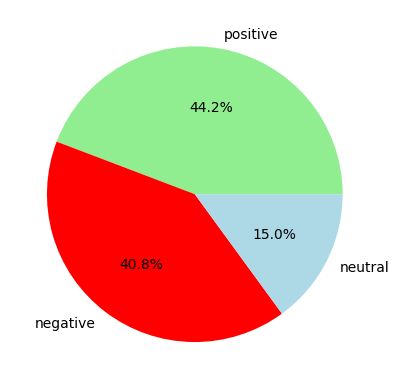

In [58]:
fig, ax = plt.subplots()
sentiment_df = df["sentiment"].value_counts()
ax.pie(sentiment_df, 
       labels=sentiment_df.index,
       autopct='%1.1f%%',
       colors=["lightgreen", "red", "lightblue"]);

### Numeric Columns

In [59]:
# Define columns to plot
df["is_compilation_int"] = df["is_compilation"].astype(int)
numeric_columns_dict = {'voting': "Voting",
                        'nr_comments': "# Comments",
                        'nr_postings_shown': "# Postings",
                        'nr_authors': "# Authors",
                        'is_compilation_int': "Is compilation"}

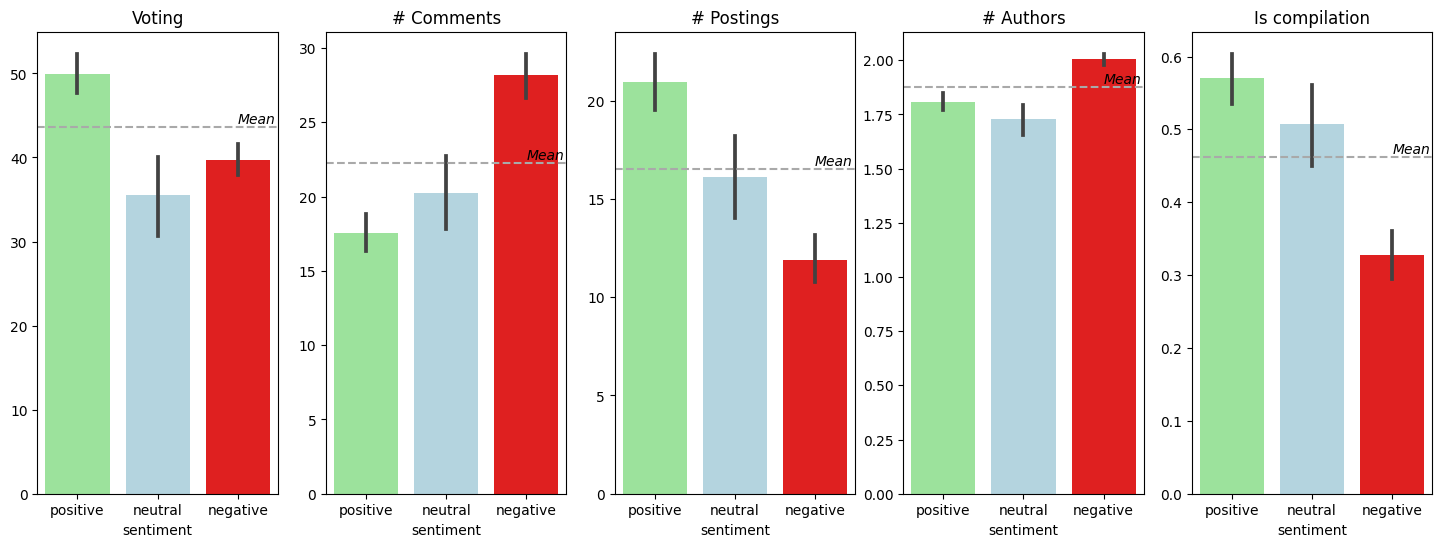

In [60]:
# Define canvas
fig, axs = plt.subplots(figsize=(18, 6), ncols=len(numeric_columns_dict))

# Plot each numeric column
for axis, col in enumerate(numeric_columns_dict.keys()):
    sns.barplot(data=df,  x="sentiment",  y=col, 
                order=["positive", "neutral", "negative"],
                palette=["lightgreen", "lightblue", "red"], 
                ax=axs[axis])
    axs[axis].set_title(numeric_columns_dict[col])
    axs[axis].set_ylabel(None)
    # Add mean-line and annotation
    axs[axis].axhline(df[col].mean(), color="darkgrey", linestyle="--")
    axs[axis].text(x=2, y=df[col].mean()*1.01, s="Mean", fontstyle="italic")

In [61]:
# Show statistical analysis from above again
stat_results_T

Variable                         Voting         # Comments         # Postings   
Stats                         Statistic p-Value  Statistic p-Value  Statistic   
Pos vs. Neg vs. Neut (F-test)    28.707   0.000     53.785   0.000     44.162  \
Pos vs. Neg                      10.196   0.000     10.631   0.000      9.063   
Pos vs. Neut                     14.445   0.000      2.729   0.138      4.840   
Neg vs. Neut                      4.248   0.158      7.901   0.000      4.223   

Variable                              # Authors         Is compilation          
Stats                         p-Value Statistic p-Value      Statistic p-Value  
Pos vs. Neg vs. Neut (F-test)   0.000    42.017   0.000         51.258   0.000  
Pos vs. Neg                     0.000     0.196   0.000          0.243   0.000  
Pos vs. Neut                    0.001     0.081   0.062          0.063   0.143  
Neg vs. Neut                    0.005     0.277   0.000          0.179   0.000

### Date Posted

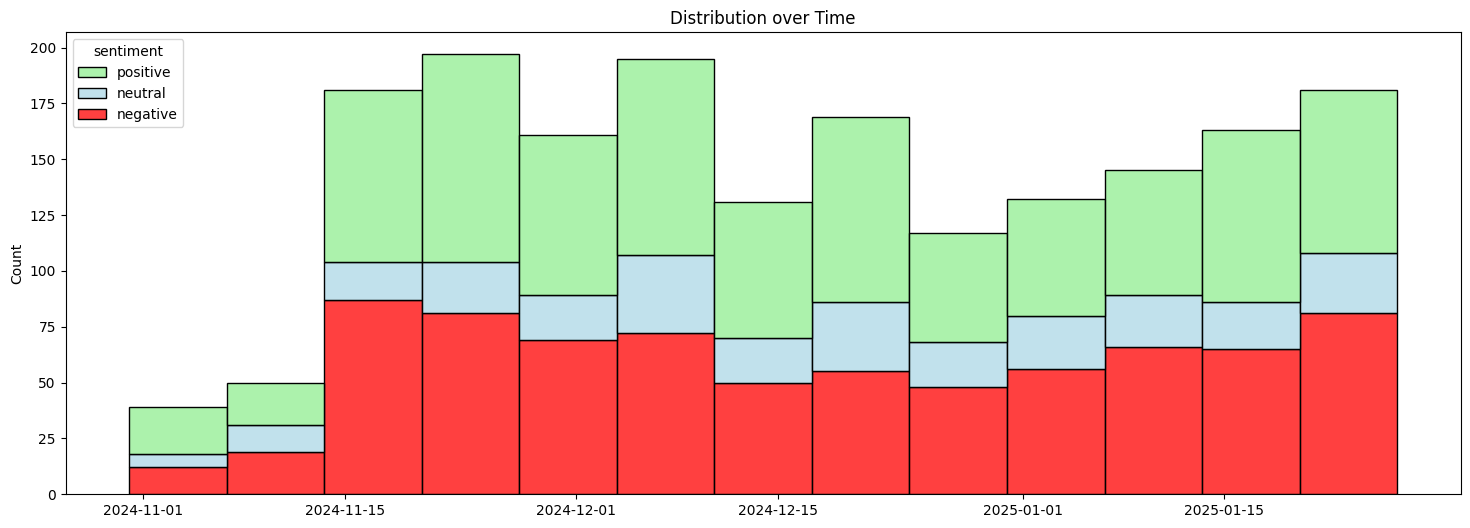

In [62]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.histplot(data=df,  x="date_posted_reformatted", 
             hue="sentiment", 
             hue_order=["positive", "neutral", "negative"],
             palette=["lightgreen", "lightblue", "red"],
             multiple="stack")
ax.set_title("Distribution over Time")
ax.set_xlabel(None);

### Categories

#### Sort data

In [63]:
# Create aggregated df for sorting categories based on share of positive postings
df_cat_pos = (df_cat_long
              .groupby(["Category Shortened", "sentiment"])
              .agg({"sentiment": "count"})
              .rename(columns={"sentiment": "sentiment_count"})
              .reset_index())
df_cat_pos = df_cat_pos[df_cat_pos["sentiment"] == "positive"]
df_cat_pos["category_count"] = df_cat_pos["Category Shortened"].map(df_cat_long["Category Shortened"].value_counts())
df_cat_pos["share_positive"] = df_cat_pos["sentiment_count"] / df_cat_pos["category_count"]
df_cat_pos = df_cat_pos.sort_values(by="share_positive", ascending=False)
df_cat_pos.head()

,Category Shortened,sentiment,sentiment_count,category_count,share_positive
44,Facts,positive,13,16,0.812
77,Jokes,positive,21,26,0.808
71,History,positive,21,26,0.808
20,Comics,positive,75,93,0.806
98,Photography,positive,31,42,0.738


In [64]:
# Sort by share of positive posts within category
category_order = {category: position for category, position in zip(df_cat_pos["Category Shortened"], range(len(df_cat_pos)))}

df_cat_long = df_cat_long.sort_values(by="Category Shortened", key=lambda col: col.map(category_order))
df_cat_long_agg = df_cat_long_agg.sort_values(by="Category Shortened", key=lambda col: col.map(category_order))

#### Plot

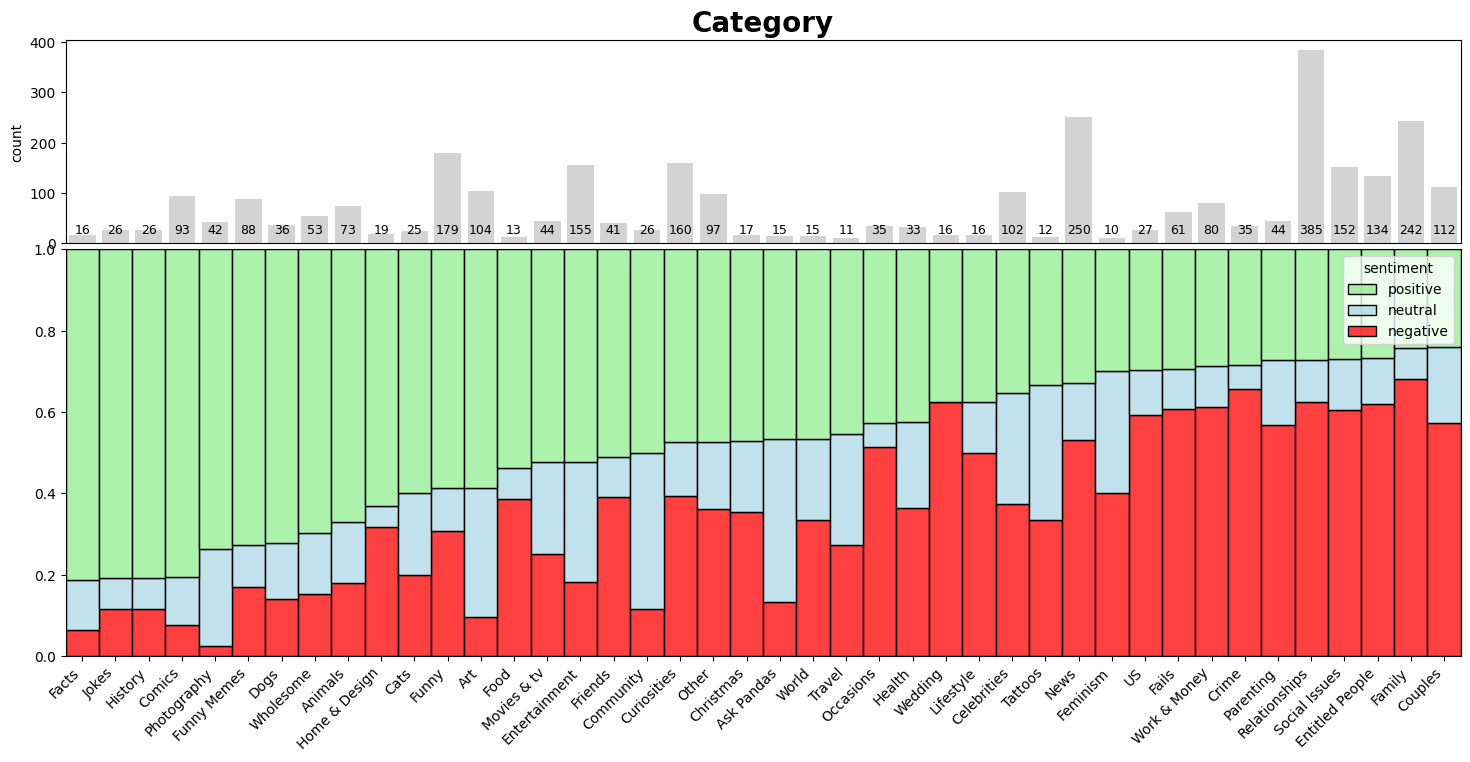

In [65]:
# Define canvas
fig, axs = plt.subplots(figsize=(18,8), height_ratios=[4, 8], nrows=2)
plt.subplots_adjust(hspace=0.02)

# Upper plot: total frequency of each category
sns.countplot(data=df_cat_long, x="Category Shortened",
              palette=["lightgrey"],
              ax=axs[0])
axs[0].set_xticks([])
axs[0].set_xlabel(None)
axs[0].set_title("Category", weight="bold", size=20)
# Label bars
for index, cat in enumerate(df_cat_long_agg.index):
    count_val = df_cat_long_agg["count"][cat]
    axs[0].text(y=20, x=index, s=count_val, ha="center", size=9)

# Bottom plot: share of pos., neut., and negative posts within each category
sns.histplot(data=df_cat_long, x="Category Shortened",
             bins=len(df_cat_long["Category Shortened"].unique()),
             hue="sentiment",
             hue_order=["positive", "neutral", "negative"],
             palette=["lightgreen", "lightblue", "red"],
             multiple="fill",
             ax=axs[1])
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_ylabel(None)
axs[1].set_xlabel(None);

### Authors' Names

#### Sort data

In [66]:
# Create aggregated df for sorting categories based on share of positive postings
df_author_pos = (df_author_long
                 .groupby(["Author Name Shortened", "sentiment"])
                 .agg({"sentiment": "count"})
                 .rename(columns={"sentiment": "sentiment_count"})
                 .reset_index())
df_author_pos = df_author_pos[df_author_pos["sentiment"] == "positive"]
df_author_pos["author_count"] = df_author_pos["Author Name Shortened"].map(df_author_long["Author Name Shortened"].value_counts())
df_author_pos["share_positive"] = df_author_pos["sentiment_count"] / df_author_pos["author_count"]
df_author_pos = df_author_pos.sort_values(by="share_positive", ascending=False)
df_author_pos.head()

,Author Name Shortened,sentiment,sentiment_count,author_count,share_positive
65,Ieva Midveryte,positive,12,13,0.923
32,Dominykas Zukas,positive,20,26,0.769
110,Mariia Tkachenko,positive,13,17,0.765
63,Hidrėlėy,positive,107,146,0.733
184,Viktorija Strelciunaite,positive,12,17,0.706


In [67]:
# Sort by share of positive posts of each autho
author_order = {author: position for author, position in zip(df_author_pos["Author Name Shortened"], range(len(df_author_pos)))}

df_author_long = df_author_long.sort_values(by="Author Name Shortened", key=lambda col: col.map(author_order))
df_author_long_agg = df_author_long_agg.sort_values(by="Author Name Shortened", key=lambda col: col.map(author_order))

#### Plot

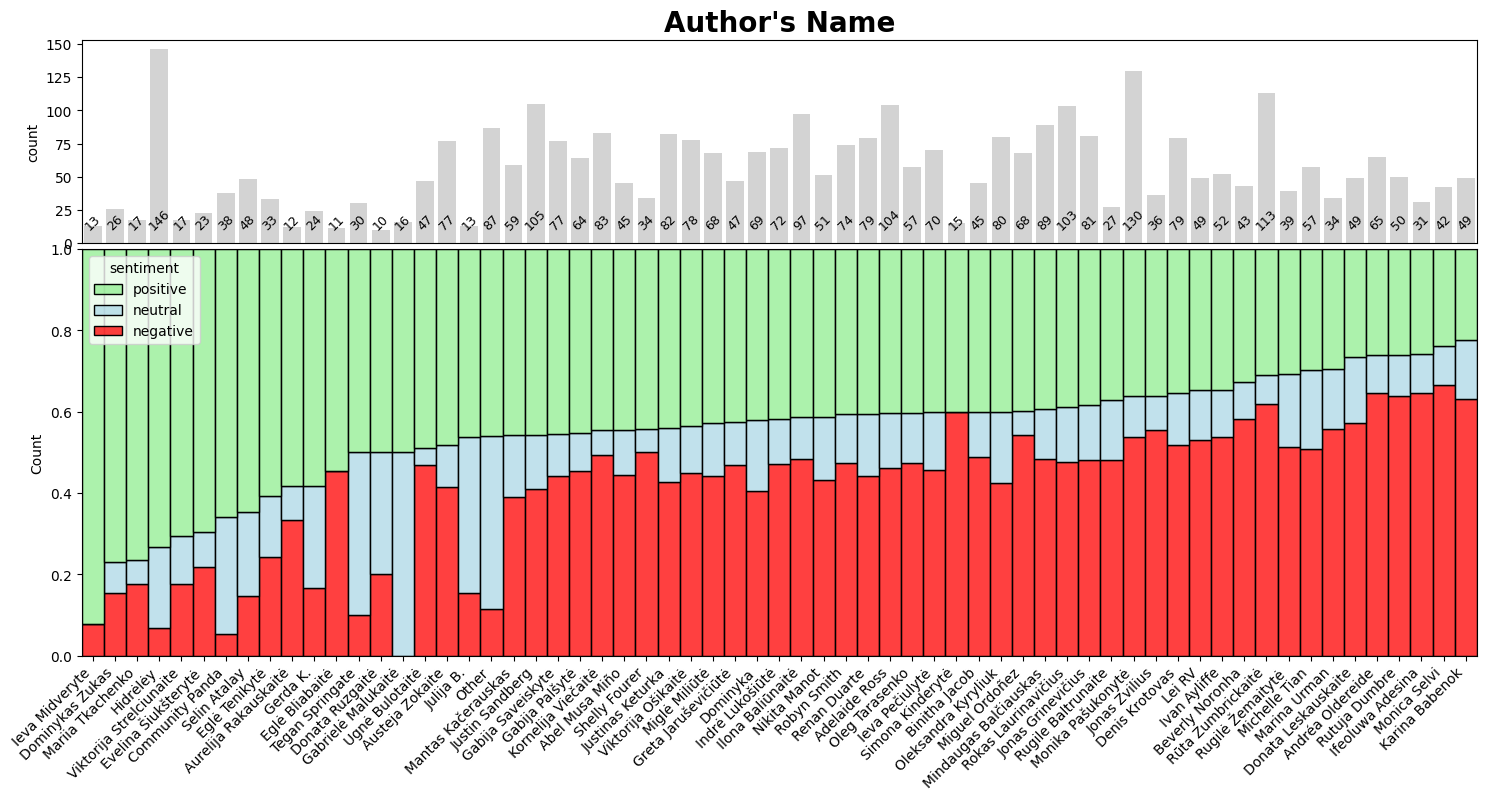

In [68]:
# Define canvas
fig, axs = plt.subplots(figsize=(18,8), height_ratios=[4, 8], nrows=2)
plt.subplots_adjust(hspace=0.02)

# Upper plot: total frequency of author names
sns.countplot(data=df_author_long,
              x="Author Name Shortened",
              palette=["lightgrey"],
              ax=axs[0])
axs[0].set_xticks([])
axs[0].set_xlabel(None)
axs[0].set_title("Author's Name", weight="bold", size=20)
# Label bars with frequency 
for index, cat in enumerate(df_author_long_agg.index):
    count_val = df_author_long_agg["count"][cat]
    axs[0].text(y=10, x=index, s=count_val, ha="center", size=9, rotation=45)

# Bottom plot: distribution of positive, neutral, and negative posts by each author
sns.histplot(data=df_author_long,
             bins=len(df_author_long["Author Name Shortened"].unique()),
             x="Author Name Shortened",
             hue="sentiment",
             hue_order=["positive", "neutral", "negative"],
             palette=["lightgreen", "lightblue", "red"],
             multiple="fill",
             ax=axs[1])
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].set_xlabel(None);

### Authors' Roles

In [69]:
# Sort by count and Author Role
df_author_long = df_author_long.sort_values(by=["role_count", "Author Role"], ascending=False)

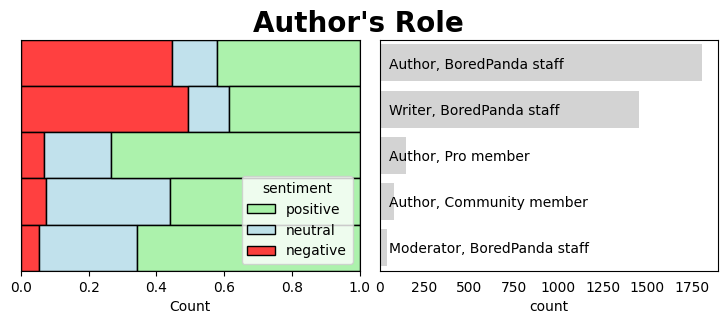

In [70]:
# Define canvas
fig, axs = plt.subplots(figsize=(9,3), ncols=2)
plt.subplots_adjust(wspace=0.06)
fig.suptitle("Author's Role", weight="bold", size=20)

# Left plot: share of sentiment given each role
sns.histplot(data=df_author_long,
             bins=len(df_author_long["Author Role"].unique()),
             y="Author Role",
             hue="sentiment",
             hue_order=["positive", "neutral", "negative"],
             palette=["lightgreen", "lightblue", "red"],
             multiple="fill",
             ax=axs[0])
axs[0].set_yticks([])
axs[0].set_ylabel(None)
sns.move_legend(axs[0], "lower right") 

# Right plot: absolute frequency of roles
sns.countplot(data=df_author_long,
              y="Author Role",
              palette=["lightgrey"],
              ax=axs[1])
axs[1].set_yticks(axs[1].get_yticks(), axs[1].get_yticklabels(), ha="left")
axs[1].tick_params(left=False, bottom=False)
axs[1].yaxis.set_tick_params(pad=-10)
axs[1].set_ylabel(None);

### Title (Wordclouds)

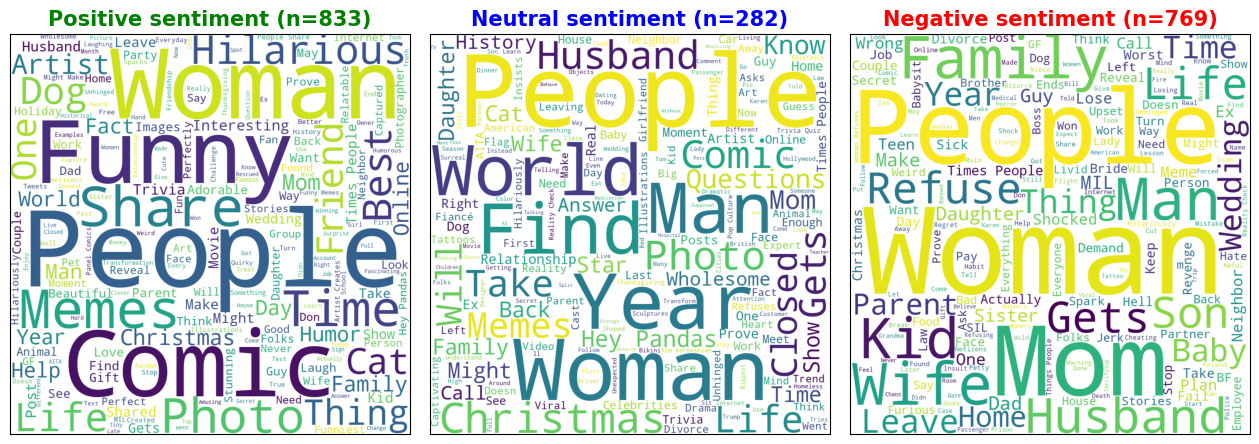

In [71]:
# Set up wordcloud module
stopwords = set(STOPWORDS)
stopwords.update(["re", "s", "t", "ve", "New", "Pics"])

wc = WordCloud(
    stopwords=stopwords,
    background_color="white",
    width=1000,
    height=1000,
    min_font_size=10
)

# Define canvas 
fig, axs = plt.subplots(figsize=(16,10), ncols=3)
plt.subplots_adjust(wspace=0.05)

# Create wordclouds of the post titles associated with the sentiments
sentiments = ["positive", "neutral", "negative"]
colors = ["green", "blue", "red"]
for axis, sentiment, color in zip(range(0,3), sentiments, colors):
    filtered_titles = df.loc[df["sentiment"] == sentiment, "title"]
    text = " ".join(filtered_titles)
    wordcloud = wc.generate(text)
    axs[axis].imshow(wordcloud)
    title_text = f"{sentiment.capitalize()} sentiment (n={len(filtered_titles)})"
    axs[axis].set_title(title_text, weight="bold", size=15, color=color)
    axs[axis].tick_params(left=False, bottom=False)
    axs[axis].set_xticklabels([])
    axs[axis].set_yticklabels([])